In [1]:
# Essentials
import pickle
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

# PyTorch
import torch
import torchvision
import torch.nn as nn  
import torch.nn.functional as F  
import torchvision.datasets as datasets  
import torchvision.transforms as transforms  
from torch.utils.data import DataLoader

In [2]:
torch.__version__

'1.9.0'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 1. Plotting histogram of materials

In [4]:
# Imagenet normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),  
        transforms.RandomHorizontalFlip(),  # augmentations
        transforms.ToTensor(),
        transforms.Normalize(mean, std)  
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

## Import resources

In [5]:
# Directories
data_dir = "/storage/intern"
label_path = "./mat/MatLB3"
params_path = "./mat/params"

In [6]:
# Define parameter
batch_size = 8
num_workers = 2
experiment = "mat"
# Load Data
train_set = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
val_set = datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_size = len(train_set)
val_size = len(val_set)
class_names = train_set.classes
num_class = len(class_names)
num_batches = math.floor(train_size/batch_size)
print(f"Number of classes: {num_class}")
print(f"Number of batches: {num_batches}")
print(class_names)

Number of classes: 31
Number of batches: 6468
['calf', 'canvas', 'canvas+leather', 'coatedcanvas', 'crocodile', 'denim', 'enamel', 'flora canvas', 'fur', 'gg crystal', 'gg embossed leather', 'gg imprime ', 'gg nylon', 'gg plus', 'gg supreme canvas', 'ggcanvas', 'guccissima', 'guccissima nylon', 'jacquard ', 'leather', 'linen', 'lizard', 'microguccissima', 'nylon', 'ostrich', 'pig', 'python', 'quilted leather', 'suede', 'velor', 'velvet']


In [7]:
# Model
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_widese_b0', pretrained=True)
in_fc = model.classifier.fc.in_features
model.classifier.fc = nn.Linear(in_fc, num_class)
# Load params
model.load_state_dict(torch.load(params_path))
model.eval()
# Labels
label_names = pickle.loads(open(label_path, "rb").read())
print(len(label_names))

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"


31


In [8]:
# Dataframe of file path and material
img_path = '/storage/gcpproddata/'
meta_path = '/storage/experiments/gucci-202202211437/csv/'
df = pd.read_csv(meta_path + 'imagepaths.csv')                      # path-bag-location dataset
df = df[df.location == 1]                                           # only need data with location 1
df1 = df[['path','bag']]                                            # remove location column
df2 = pd.read_csv(meta_path + 'bagsgucci.csv')[['bag', 'mat']]      # Bag-mat dataset
meta_df = df1.merge(df2, how='left', on='bag').drop('bag', axis=1)  # Merge on 2 dataset
meta_df = meta_df.replace(r'^\s*$', np.NaN, regex=True)             # Replace all empty string by NULL
meta_df = meta_df.dropna(axis=0)
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65209 entries, 61 to 72007
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    65209 non-null  object
 1   mat     65209 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [9]:
# Take a quick look at class distribution
label_df = meta_df["mat"]
freq = label_df.value_counts(normalize=True)
freq = round(freq, 4) * 100     # convert to percentage
print(freq)    

leather                30.70
gg supreme canvas      19.39
canvas                 17.74
ggcanvas                9.36
coatedcanvas            4.71
guccissima              4.23
microguccissima         1.74
nylon                   1.28
suede                   1.27
flora canvas            1.22
guccissima nylon        1.04
gg plus                 1.04
python                  0.82
gg imprime              0.66
calf                    0.65
enamel                  0.59
denim                   0.49
velvet                  0.40
gg embossed leather     0.28
gg nylon                0.24
gg crystal              0.23
linen                   0.21
jacquard                0.15
ostrich                 0.15
crocodile               0.14
lizard                  0.13
quilted leather         0.11
leather+canvas          0.10
canvas+leather          0.10
wool                    0.10
velor                   0.07
pig                     0.07
nubuck                  0.06
fur                     0.06
suede+leather 

## Pick top-20 class for visualization

In [10]:
robust_freq = pd.DataFrame(freq).iloc[:20]

## Histogram

<Figure size 1152x1008 with 0 Axes>

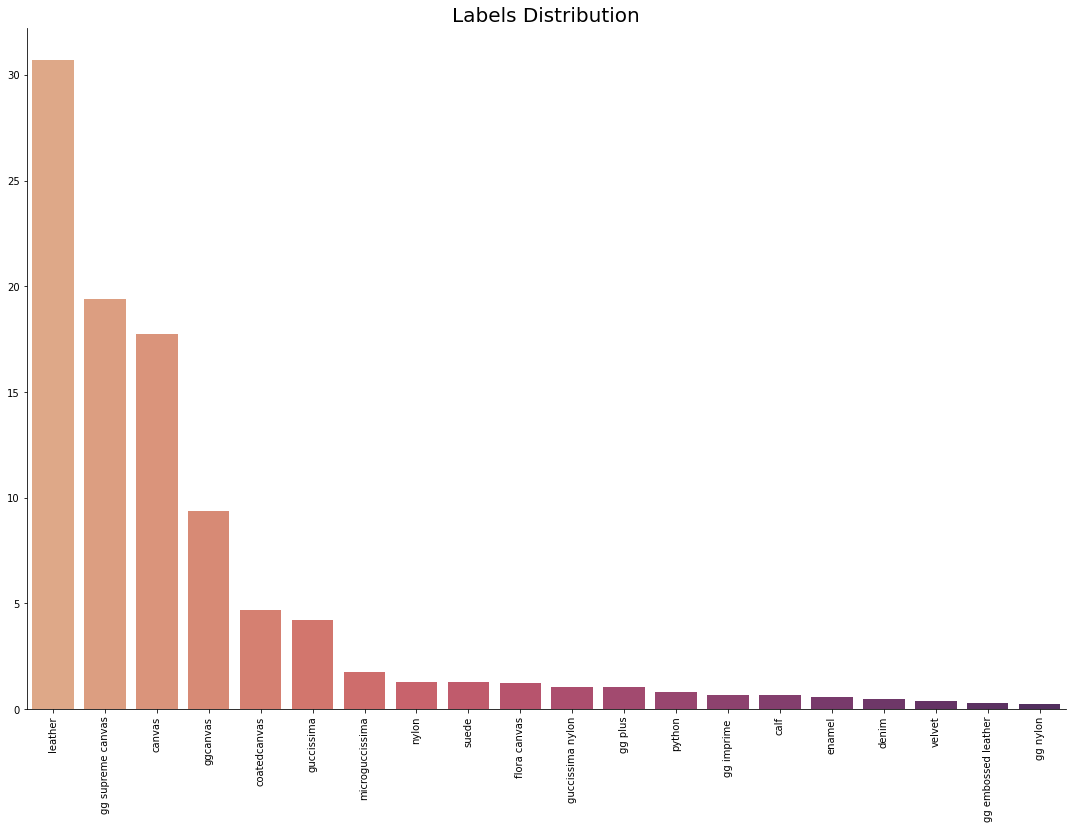

In [11]:
# Histogram with robust frequency labels
robust_freq = robust_freq.transpose()   # transpose for visualization

plt.figure(figsize=(16, 14))
sns.catplot(data=robust_freq, kind="bar", height=10, aspect=1.5, legend_out=True, palette="flare")
plt.xticks(rotation=90)
plt.title('Labels Distribution', fontsize=20)
# plt.savefig('LabelDist.png')
plt.show()

# 2. Plot a confusion matrix for materials.

## For first time

In [19]:
model.eval()
model.to(device)
prob = []   # probability
y_pred = [] # prediction labels
y_true = [] # tru labels
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        labels = labels.to(device)
        images = images.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        labels = labels.detach().cpu().numpy()
        outputs = outputs.detach().cpu().numpy()
        predicted = predicted.detach().cpu().numpy()
        prob.append(outputs)
        y_pred.append(predicted)
        y_true.append(labels)

prob = np.concatenate(prob)        
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

In [39]:
pred_path = "./mat/pred"
true_path = "./mat/true"
prob_path = "./mat/prob"

In [40]:
# Pickle label and prediction
f = open(pred_path, "wb")
f.write(pickle.dumps(y_pred))
f.close()

f = open(true_path, "wb")
f.write(pickle.dumps(y_true))
f.close()

f = open(prob_path, "wb")
f.write(pickle.dumps(prob))
f.close()

## Reimport probability, predict and true labels

In [9]:
# y_pred = pickle.loads(open(pred_path, "rb").read())
# y_true = pickle.loads(open(true_path, "rb").read())
# prob = pickle.loads(open(prob_path, "rb").read())

## Confusion matrix:

Confusion Matrix with Normalized

In [31]:
# Function for lower triangle confusion matrix
def tril_confusion_matrix(y_true, y_pred, normalize = None):
    """Create a lower triangle confusion matrix

    Args:
        y_true (NumpyArray): true labels
        y_pred (NumpyArray): prediction labels
        normalize ("true", "pred", "all", None optional): Choose whether normalize or not. Defaults to None.
    """
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    # Create an mask for triangle
    mask = np.ones_like(cm, dtype=np.bool)
    mask[np.tril_indices_from(mask)] = False

    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(16, 14))
    ax = plt.subplot()

    sns.heatmap(cm, ax=ax, mask=mask, cmap="Blues", square=True, linewidths=.5)

    ax.set_xlabel('Predicted Label', fontsize=20)
    ax.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)
    plt.title('Lower Triangle Confusion Matrix', fontsize=20)
    # plt.savefig('ConfusionMat.png')
    plt.show()

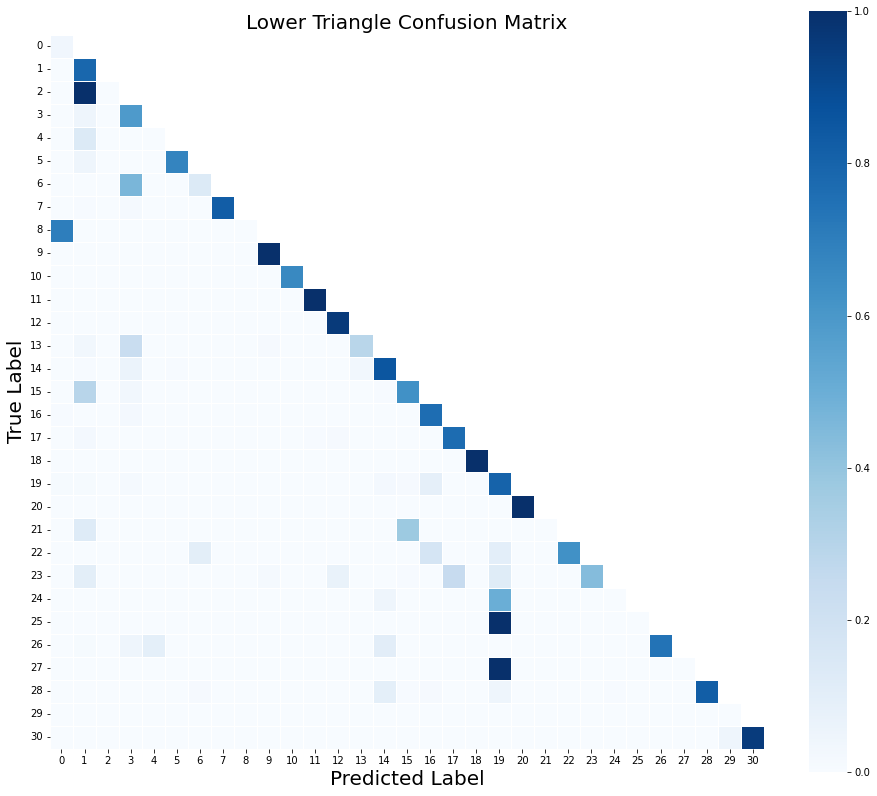

In [32]:
tril_confusion_matrix(y_true, y_pred, normalize="true")

Confusion matrix without Normalized

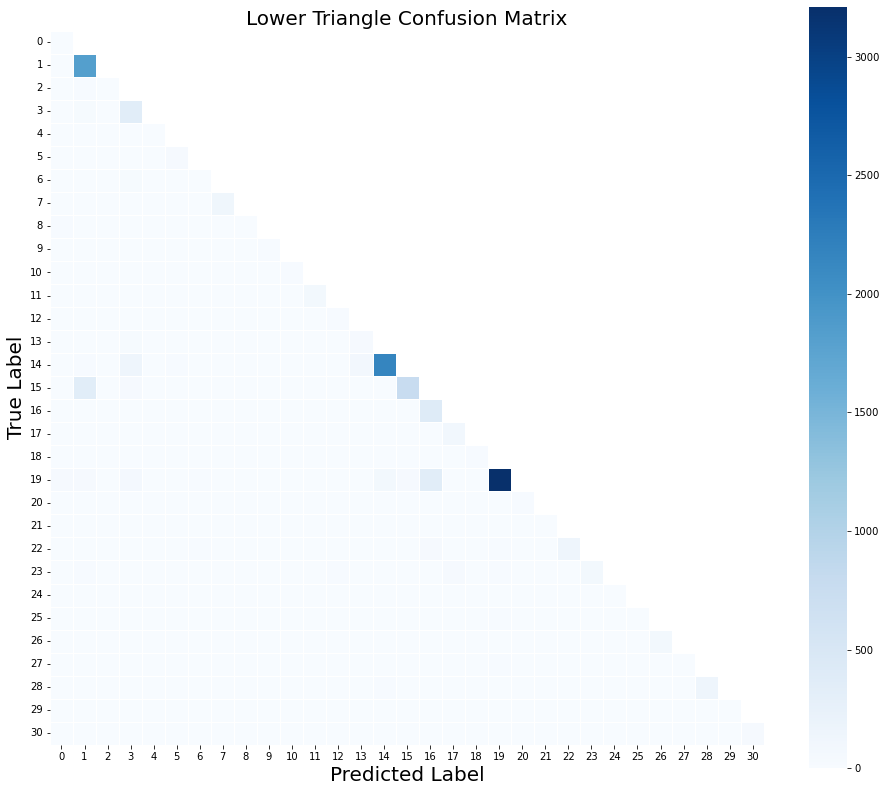

In [33]:
tril_confusion_matrix(y_true, y_pred)

In [35]:
a = [19, 25, 27]
for num in a:
    print(label_names[num])

leather
pig
quilted leather


# 3. Take a look at results again

## The rate of wrong labeling in batch

In [36]:
wrong_idx = y_pred != y_true
print(f"Rate of wrong label: {round(wrong_idx.sum() / len(wrong_idx)*100, 2)}%")

Rate of wrong label: 24.9%


## The TODO: Visualize the worst errors

In [37]:
def find_the_worst_error(prob, y_pred, y_true, label_names, data_ds, batch_size):
    """Input numpy array with probability, prediction labels, true labels, dataset, batch size.
    Which return the worst prediction picture, predict and label

    Args:
        prob (ndarray): probability after prediction
        y_pred (numpy.parray): prediction label of dataset
        y_true (numpy.array): true label of dataset
        data_ds (tf.dataset): dataset
        batch_size (int): batch size of dataset
        label_names (list): list of labels class name

    Returns:
        _type_: _description_
    """
    
    # Find index
    mask = y_pred != y_true
    subset_idx = np.argmax(prob[mask]) // len(label_names)      # find the max probability with mask
    parent_idx = np.arange(prob.shape[0])[mask][subset_idx]     # find index in parent dataset
    batch_idx = parent_idx // batch_size                        # find batch
    idx = parent_idx % batch_size                               # find index in batch
    
    # Variable return
    label = label_names[y_true[parent_idx]]                     # label of the worst error
    worst_prob = max(prob[mask].flatten())
    predict = label_names[y_pred[parent_idx]]                   # prediction of the worst error
    batch = list(data_ds.skip(batch_idx).take(1))[0][0].numpy() # remove the label
    picture = batch[idx]
    
    # Print result
    plt.imshow(picture.astype(np.uint8))
    plt.axis("off")
    print(f"The prediction label is: {predict}")
    print(f"The true label is: {label}")
    print(f"The probability is {worst_prob * 100}%")
    # return picture, worst_pred, label

In [38]:
find_the_worst_error(prob=prob, 
                     y_pred=y_pred, 
                     y_true=y_true, 
                     label_names=label_names, 
                     data_ds=val_set, 
                     batch_size=batch_size)

AttributeError: 'ImageFolder' object has no attribute 'skip'